In [23]:
import jax
import jax.numpy as jnp

from non_local_detector.likelihoods.common import gaussian_pdf

def kde(
    eval_points: jnp.ndarray, samples: jnp.ndarray, std: jnp.ndarray
) -> jnp.ndarray:
    """Kernel density estimation.

    Parameters
    ----------
    eval_points : jnp.ndarray, shape (n_eval_points, n_dims)
    samples : jnp.ndarray, shape (n_samples, n_dims)
    std : jnp.ndarray, shape (n_dims,)
        Standard deviation of the Gaussian kernel.

    Returns
    -------
    density_estimate : jnp.ndarray, shape (n_eval_points,)
    """
    distance = jnp.ones((samples.shape[0], eval_points.shape[0]))

    for dim_eval_points, dim_samples, dim_std in zip(eval_points.T, samples.T, std):
        distance *= gaussian_pdf(
            jnp.expand_dims(dim_eval_points, axis=0),
            jnp.expand_dims(dim_samples, axis=1),
            dim_std,
        )
    return jnp.mean(distance, axis=0)


def block_kde(
    eval_points: jnp.ndarray,
    samples: jnp.ndarray,
    std: jnp.ndarray,
    block_size: int = 100,
) -> jnp.ndarray:
    n_eval_points = eval_points.shape[0]
    density = jnp.zeros((n_eval_points,))
    for start_ind in range(0, n_eval_points, block_size):
        block_inds = slice(start_ind, start_ind + block_size)
        density = jax.lax.dynamic_update_slice(
            density,
            kde(eval_points[block_inds], samples, std),
            (start_ind,),
        )

    return density

In [66]:
n_eval_points = 1
n_dims = 5
n_samples = 1

eval_points = jnp.ones((n_eval_points, n_dims))
samples = jnp.ones((n_samples, n_dims))
std = jnp.ones((n_dims,))

block_kde(eval_points, samples, std).shape

(1,)

(1,)

In [57]:
@jax.jit
def kde(
    eval_points: jnp.ndarray, samples: jnp.ndarray, std: jnp.ndarray
) -> jnp.ndarray:
    """Kernel density estimation.

    Parameters
    ----------
    eval_points : jnp.ndarray, shape (n_eval_points, n_dims)
        Evaluation points.
    samples : jnp.ndarray, shape (n_samples, n_dims)
        Training samples.
    std : jnp.ndarray, shape (n_dims,)
        Standard deviation of the Gaussian kernel.

    Returns
    -------
    density_estimate : jnp.ndarray, shape (n_eval_points,)
    """

    def single_kde(eval_point):
        return jnp.mean(
            jax.vmap(lambda sample: gaussian_pdf(sample, eval_point, std))(samples)
        )

    return jax.vmap(single_kde)(eval_points)

Array(True, dtype=bool)

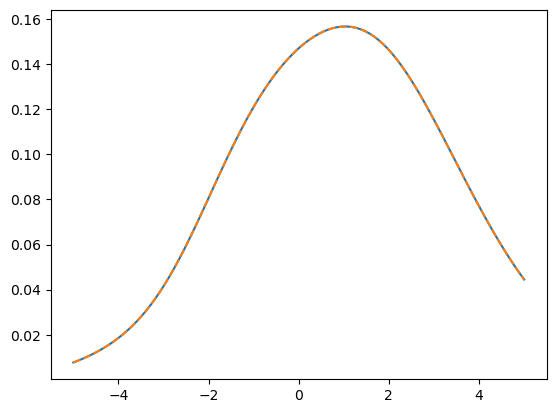

In [60]:
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

n_eval_points = 100
n_dims = 1

eval_points = jnp.linspace(-5, 5, n_eval_points).reshape(-1, 1)
samples = multivariate_normal(mean=1, cov=5).rvs(1000).reshape(-1, 1)

std = jnp.ones((n_dims,))

sk_kde = jnp.exp(KernelDensity(kernel="gaussian", bandwidth=1).fit(samples).score_samples(eval_points))
jax_kde = kde(eval_points, samples, std)

plt.plot(eval_points, sk_kde)
plt.plot(eval_points, jax_kde, linestyle="--")

jnp.allclose(sk_kde, jax_kde)

Text(0.5, 1.0, 'jax')

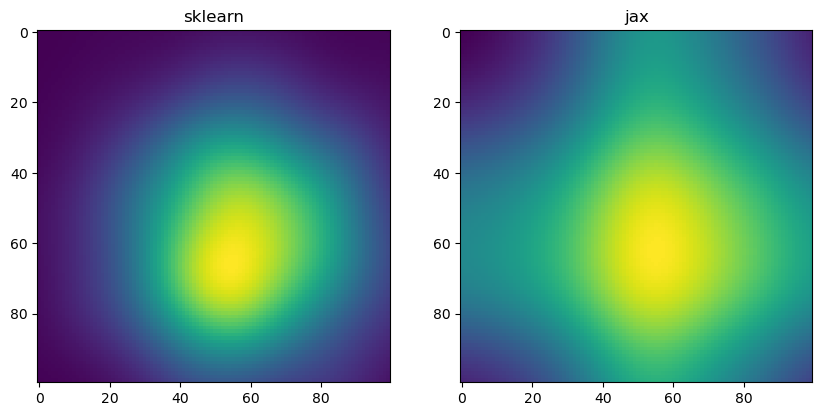

In [63]:
# 2D example
n_eval_points = 100
n_dims = 2

eval_points = jnp.linspace(-5, 5, n_eval_points)
eval_points = jnp.array(jnp.meshgrid(eval_points, eval_points)).reshape(2, -1).T
samples = multivariate_normal(mean=[1, 1], cov=[[5, 0], [0, 5]]).rvs(1000)


std = jnp.ones((n_dims,))
sk_kde = jnp.exp(KernelDensity(kernel="gaussian", bandwidth=1).fit(samples).score_samples(eval_points
))
jax_kde = kde(eval_points, samples, std)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sk_kde.reshape(n_eval_points, n_eval_points))
axes[0].set_title("sklearn")
axes[1].imshow(jax_kde.reshape(n_eval_points, n_eval_points))
axes[1].set_title("jax")